# GRU for Time Series Prediction

In this notebook, we will demonstrate how to use Gated Recurrent Units (GRU) neural networks for time series prediction.


In [1]:
# Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense  # Note the change to GRU here
from sklearn.preprocessing import MinMaxScaler


## Data Preparation

First, let's load and visualize the Airline Passengers dataset.


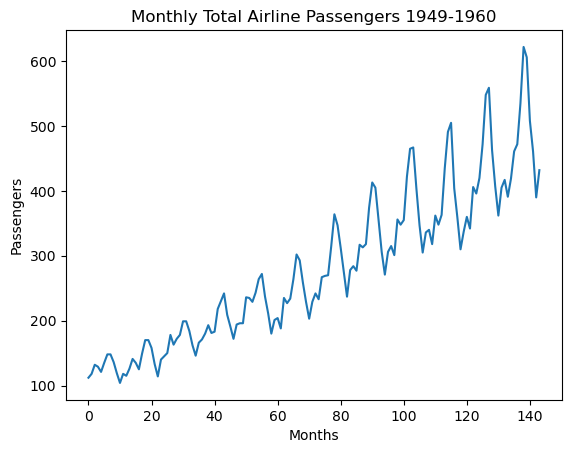

In [2]:
# Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
dataframe = pd.read_csv(url, usecols=[1], engine='python')
plt.plot(dataframe)
plt.xlabel("Months")
plt.ylabel("Passengers")
plt.title("Monthly Total Airline Passengers 1949-1960")
plt.show()


### Data Preprocessing

Before training a GRU model, we need to preprocess our data. This involves scaling our data and converting it into the right shape.


In [3]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataframe.values.astype('float32'))

# Split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


### Create Dataset Matrix

This utility function creates a dataset matrix. Given data, and choosing a certain time step, it will create input-output pairs.


In [4]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Reshape into X=t and Y=t+1, choosing a timestep of 3
look_back = 3
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


## GRU Model Building & Training


In [5]:
# Create and fit the GRU network
model = Sequential()
model.add(GRU(4, input_shape=(look_back, 1)))  # Change LSTM to GRU here
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)


Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Epoch 1/100
92/92 - 3s - loss: 0.0071 - 3s/epoch - 32ms/step
Epoch 2/100
92/92 - 0s - loss: 0.0049 - 486ms/epoch - 5ms/step
Epoch 3/100
92/92 - 0s - loss: 0.0041 - 482ms/epoch - 5ms/step
Epoch 4/100
92/92 - 1s - loss: 0.0035 - 518ms/epoch - 6ms/step
Epoch 5/100
92/92 - 0s - loss: 0.0032 - 498ms/epoch - 5ms/step
Epoch 6/100
92/92 - 0s - loss: 0.0030 - 491ms/epoch - 5ms/step
Epoch 7/100
92/92 - 1s - loss: 0.0029 - 505ms/epoch - 5ms/step
Epoch 8/100
92/92 - 1s - loss: 0.0029 - 510ms/epoch - 6ms/step
Epoch 9/100
92/92 - 1s - loss: 0.0030 - 524ms/epoch - 6ms/step
Epoch 10/100
92/92 - 1s - loss: 0.0028 - 503ms/epoch - 5ms/step
Epoch 11/100
92/92 - 0s - loss: 0.0027 - 493ms/epoch - 5ms/step
Epoch 12/100
92/92 - 0s - loss: 0.0028 - 496ms/epoch - 5ms/step
Epoch 13/100
92/92 - 0s - loss: 0.0027 - 493ms/epoch - 5ms/step
Epoch 14/100
92/92 - 0s - loss: 0.0027 - 498ms/epoch - 5ms/step
Epoch 15/100
92/92 - 0s - loss: 0

## Model Evaluation


In [6]:
# Make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

# Calculate root mean squared error
trainScore = np.sqrt(((trainPredict-y_train)**2).mean())
testScore = np.sqrt(((testPredict-y_test)**2).mean())
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))


2/2 [==============================] - 0s 20ms/step
Train Score: 97.65 RMSE
Test Score: 104.96 RMSE


## Visualizing Predictions


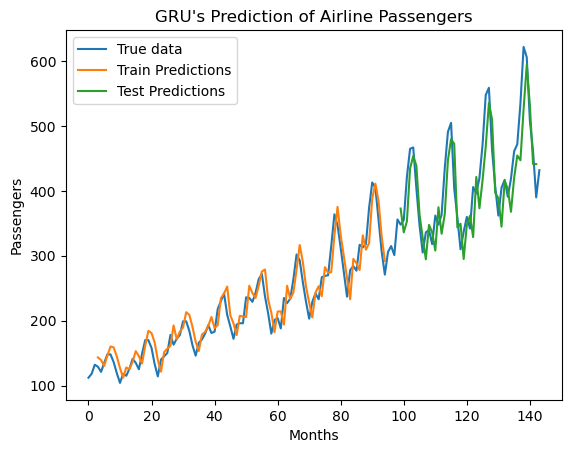

In [7]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label="True data")
plt.plot(trainPredictPlot, label="Train Predictions")
plt.plot(testPredictPlot, label="Test Predictions")
plt.xlabel("Months")
plt.ylabel("Passengers")
plt.title("GRU's Prediction of Airline Passengers")
plt.legend()
plt.show()
